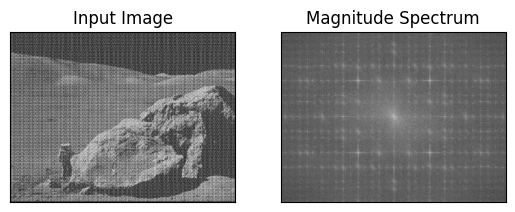

In [104]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img = cv.imread('periodic_noise.JPG', cv.IMREAD_GRAYSCALE)

dft = cv.dft(np.float32(img),flags = cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

magnitude_spectrum = 20*np.log(cv.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

In [105]:
chosen_filter = "notchdots"

In [106]:
#Filter creating
# Low pass filter
if chosen_filter == "lowpass":
  mask = np.zeros((img.shape[0],img.shape[1],2),np.uint8)
  centerX, centerY = (int(img.shape[0] / 2),int(img.shape[1] / 2))
  mask[centerX-50:centerX+50, centerY - 50:centerY+50,:] = 1

In [107]:
#Filter creating
# High pass filter
if chosen_filter == "highpass":
  mask = np.ones((img.shape[0],img.shape[1],2),np.uint8)
  centerX, centerY = (int(img.shape[0] / 2),int(img.shape[1] / 2))
  mask[centerX-50:centerX+50, centerY - 50:centerY+50,:] = 0

In [108]:
#Filter creating
# Periodic noise filter (notch filter) - dots
if chosen_filter == "notchdots":
  mask = np.ones((img.shape[0],img.shape[1],2),np.uint8)
  centerX, centerY = (int(img.shape[0] / 2),int(img.shape[1] / 2))

  def generate_sym_coords(center_x, center_y, offsets):
    coords = []
    for dx, dy in offsets:
        coords.extend([
            (center_x + dx, center_y + dy),
            (center_x - dx, center_y + dy),
            (center_x + dx, center_y - dy),
            (center_x - dx, center_y - dy)
        ])
    return coords

  offsets = [(125, 50), (125, 125), (50, 125), (0, 250), (250, 0), (0, 175), (175, 0)]
  noise_coords = generate_sym_coords(centerX, centerY, offsets)

  for x, y in noise_coords:
  #cv.circle(mask, (y, x), 6, (0,0), thickness=-1)
    mask[x-5:x+5, y - 5:y+5,:] = 0

In [109]:
#Filter creating
# Periodic noise filter (notch filter) - lines
if chosen_filter == "notchlines":
  mask = np.ones((img.shape[0],img.shape[1],2),np.uint8)
  centerX, centerY = (int(img.shape[0] / 2),int(img.shape[1] / 2))

  line_width = 5
  dist = [0, 50, 125, 175, 250]

  for d in dist:
      # Vertical
      y_start = max(centerY + d - int(line_width/2), 0)
      y_end = min(centerY + d + int(line_width/2), img.shape[1])
      mask[:, y_start:y_end, :] = 0

      y_start = max(centerY - d - int(line_width/2), 0)
      y_end = min(centerY - d + int(line_width/2), img.shape[1])
      mask[:, y_start:y_end, :] = 0

      # Horizontal
      x_start = max(centerX + d - int(line_width/2), 0)
      x_end = min(centerX + d + int(line_width/2), img.shape[0])
      mask[x_start:x_end, :, :] = 0

      x_start = max(centerX - d - int(line_width/2), 0)
      x_end = min(centerX - d + int(line_width/2), img.shape[0])
      mask[x_start:x_end, :, :] = 0

  mask[centerX-50+int(line_width/2):centerX+50-int(line_width/2), centerY - 50+int(line_width/2):centerY+50-int(line_width/2),:] = 1

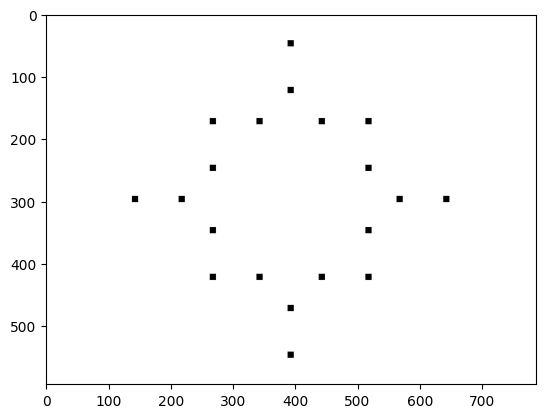

In [110]:
plt.imshow(mask[:,:,0], cmap = 'gray')

In [111]:
# Filtering
dft_shift = dft_shift*mask

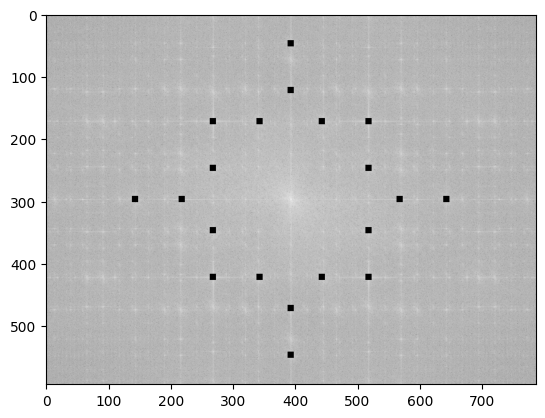

In [112]:
filtering_magn_res = 20*np.log(cv.magnitude(dft_shift[:,:,0], dft_shift[:,:,1])+1e-6)
plt.imshow(filtering_magn_res, cmap='gray')

In [113]:
#fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(dft_shift)
img_back = cv.idft(f_ishift)
img_back = cv.magnitude(img_back[:,:,0],img_back[:,:,1])

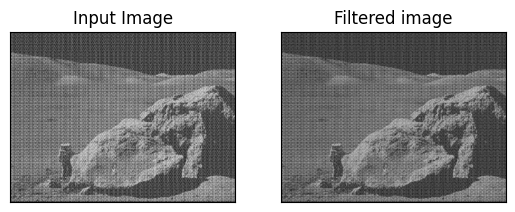

In [114]:
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Filtered image'), plt.xticks([]), plt.yticks([])
plt.show()

In [115]:
# Реализуйте высокочастотную фильтрацию на основе ядра Гаусса
# Реализуйте удаление периодического шума